In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2

/gpfs/space/home/dmytrosh/counterfactual-search


In [2]:
# !nvidia-smi

In [ ]:
# !python tools/train.py -c configs/classification/resnet18_tsm-controls_kits_tumors.yaml

In [3]:
import os
import random
import shutil

import numpy as np
import torch
import yaml
from easydict import EasyDict as edict

from src.models import build_model
from src.trainers import build_trainer
from src.utils.generic_utils import seed_everything


# config_path = 'configs/counterfactual/tsm_synthetic.yaml'
# config_path = 'configs/classification/resnet34_tsm-v2_only_cysts.yaml'
# config_path = 'configs/classification/resnet18_kits_only_cysts.yaml'
# config_path = 'configs/classification/resnet18_tsm-controls_kits_tumors.yaml'
config_path = 'configs/classification/resnet18_tsm_synthetic_only_kidneys_large.yaml'

with open(config_path) as fid:
    opt = yaml.safe_load(fid)
    opt = edict(opt)
seed_everything(opt.seed)

model = build_model(opt.task_name, opt=opt.model, img_size=opt.dataset.img_size)
trainer = build_trainer(opt.task_name, opt, model, None)

/gpfs/space/home/dmytrosh/counterfactual-search/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/space/home/dmytrosh/counterfactual-search/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[2023-12-02 13:33:39|INFO] - ================ Session (Sat Dec  2 13:33:39 2023) ================
[2023-12-02 13:33:39|INFO] - Logging directory: training_logs/classification/convnext_base-December-02-2023_01+33PM-5d4a2f9-tsm_synth-large_convnext_base_aug


In [18]:
# (train_loader, val_loader), cf_labels = trainer.get_dataloaders(ret_counterfactual_labels=True)
train_loader, val_loader = trainer.get_dataloaders()

s0165.nii has no slices for classes: ['kidney']
s0560.nii has no slices for classes: ['kidney']
s0627.nii has no slices for classes: ['kidney']
s1187.nii has no slices for classes: ['kidney']
Instantiated training dataset for number of samples: 23903
s0261.nii has no slices for classes: ['kidney']
s0450.nii has no slices for classes: ['kidney']
Instantiated validation dataset for number of samples: 6657


tensor([[[0.5472, 0.4296, 0.2818,  ..., 0.0095, 0.0101, 0.0095],
         [0.4949, 0.3774, 0.2419,  ..., 0.0101, 0.0095, 0.0081],
         [0.4365, 0.3388, 0.2254,  ..., 0.0081, 0.0081, 0.0081],
         ...,
         [0.2302, 0.2020, 0.1477,  ..., 0.0088, 0.0088, 0.0088],
         [0.2584, 0.2316, 0.1786,  ..., 0.0095, 0.0108, 0.0115],
         [0.3127, 0.2673, 0.1937,  ..., 0.0081, 0.0088, 0.0088]]],
       dtype=torch.float64)

In [27]:
from batchgenerators.dataloading.single_threaded_augmenter import SingleThreadedAugmenter
from batchgenerators.transforms.abstract_transforms import AbstractTransform, Compose
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, \
    ContrastAugmentationTransform, GammaTransform
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform, MirrorTransform
from batchgenerators.transforms.utility_transforms import RemoveLabelTransform, RenameTransform, NumpyToTensor
from batchgenerators.utilities.file_and_folder_operations import join, load_json, isfile, save_json, maybe_mkdir_p

tr_transforms = []

patch_size_spatial = 256
rotation_for_DA = {
    'x': (-np.pi, np.pi),
    'y': 0,
    'z': 0
}
order_resampling_data = 3
# border_val_seg = -1
border_val_seg = 0
order_resampling_seg = 1
ignore_axes=None

mirror_axes=(0, 1)

tr_transforms.append(SpatialTransform(
    (patch_size_spatial, patch_size_spatial), patch_center_dist_from_border=None,
    do_elastic_deform=False, alpha=(0, 0), sigma=(0, 0),
    do_rotation=True, angle_x=rotation_for_DA['x'], angle_y=rotation_for_DA['y'], angle_z=rotation_for_DA['z'],
    p_rot_per_axis=1,  # todo experiment with this
    do_scale=True, scale=(0.7, 1.4),
    border_mode_data="constant", border_cval_data=0, order_data=order_resampling_data,
    border_mode_seg="constant", border_cval_seg=border_val_seg, order_seg=order_resampling_seg,
    random_crop=False,  # random cropping is part of our dataloaders
    p_el_per_sample=0, p_scale_per_sample=0.2, p_rot_per_sample=0.2,
    independent_scale_for_each_axis=False  # todo experiment with this
))

tr_transforms.append(GaussianNoiseTransform(p_per_sample=0.1))
tr_transforms.append(GaussianBlurTransform((0.5, 1.), different_sigma_per_channel=True, p_per_sample=0.2,
                                           p_per_channel=0.5))
tr_transforms.append(BrightnessMultiplicativeTransform(multiplier_range=(0.75, 1.25), p_per_sample=0.15))
tr_transforms.append(ContrastAugmentationTransform(p_per_sample=0.15))
tr_transforms.append(SimulateLowResolutionTransform(zoom_range=(0.5, 1), per_channel=True,
                                                    p_per_channel=0.5,
                                                    order_downsample=0, order_upsample=3, p_per_sample=0.25,
                                                    ignore_axes=ignore_axes))
tr_transforms.append(GammaTransform((0.7, 1.5), True, True, retain_stats=True, p_per_sample=0.1))
tr_transforms.append(GammaTransform((0.7, 1.5), False, True, retain_stats=True, p_per_sample=0.3))

if mirror_axes is not None and len(mirror_axes) > 0:
    tr_transforms.append(MirrorTransform(mirror_axes))

# tr_transforms.append(RemoveLabelTransform(-1, 0))

# tr_transforms.append(RenameTransform('seg', 'target', True))

# if regions is not None:
#     # the ignore label must also be converted
#     tr_transforms.append(ConvertSegmentationToRegionsTransform(list(regions) + [ignore_label]
#                                                                if ignore_label is not None else regions,
#                                                                'target', 'target'))

# if deep_supervision_scales is not None:
#     tr_transforms.append(DownsampleSegForDSTransform2(deep_supervision_scales, 0, input_key='target',
#                                                       output_key='target'))
# tr_transforms.append(NumpyToTensor(['data', 'target'], 'float'))
tr_transforms = Compose(tr_transforms)
# return tr_transforms
tr_transforms

Compose ( [SpatialTransform( independent_scale_for_each_axis = False, p_rot_per_sample = 0.2, p_scale_per_sample = 0.2, p_el_per_sample = 0, data_key = 'data', label_key = 'seg', patch_size = (256, 256), patch_center_dist_from_border = None, do_elastic_deform = False, alpha = (0, 0), sigma = (0, 0), do_rotation = True, angle_x = (-3.141592653589793, 3.141592653589793), angle_y = 0, angle_z = 0, do_scale = True, scale = (0.7, 1.4), border_mode_data = 'constant', border_cval_data = 0, order_data = 3, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 1, random_crop = False, p_rot_per_axis = 1, p_independent_scale_per_axis = 1 ), GaussianNoiseTransform( p_per_sample = 0.1, data_key = 'data', noise_variance = (0, 0.1), p_per_channel = 1, per_channel = False ), GaussianBlurTransform( p_per_sample = 0.2, different_sigma_per_channel = True, p_per_channel = 0.5, data_key = 'data', blur_sigma = (0.5, 1.0), different_sigma_per_axis = False, p_isotropic = 0 ), BrightnessMultiplicative

In [35]:
slice = dataset[0]['image'].numpy()[None]
slice.shape

(1, 1, 238, 145)

(1, 1, 256, 256)


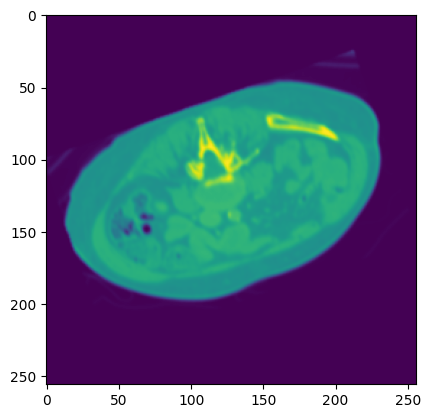

In [100]:
augm = tr_transforms(data=slice)
print(augm['data'].shape)
plt.imshow(augm['data'].squeeze())

s0165.nii has no slices for classes: ['kidney']
s0560.nii has no slices for classes: ['kidney']
s0627.nii has no slices for classes: ['kidney']
s1187.nii has no slices for classes: ['kidney']
Instantiated training dataset for number of samples: 23903
s0261.nii has no slices for classes: ['kidney']
s0450.nii has no slices for classes: ['kidney']
Instantiated validation dataset for number of samples: 6657


In [8]:
# cf_labels.sum()

In [9]:
# trainer.validation_epoch(val_loader)

In [10]:
# from src.datasets import get_dataloaders
# from src.datasets.augmentations import get_transforms
# from src.models.classifier import compute_sampler_condition_labels, predict_probs
# self = trainer
# transforms = get_transforms(self.opt.dataset)
# # compute sampler labels to create batches with uniformly distributed labels
# params = edict(self.opt.dataset, use_sampler=False, shuffle_test=False)
# # GAN's train data is expected to be classifier's validation data
# train_loader, _ = get_dataloaders(params, {'train': transforms['val'], 'val': transforms['train']})
# # posterior_probs, _ = predict_probs(train_loader, self.model.classifier_f, task='binary' if self.model.n_classes == 1 else 'multiclass')
# # sampler_labels = compute_sampler_condition_labels(posterior_probs, self.model.explain_class_idx, self.model.num_bins)

In [17]:
from src.datasets.augmentations import get_transforms
from src.models.classifier import compute_sampler_condition_labels, predict_probs

self = trainer

transforms = get_transforms(self.opt.dataset)
transforms


{'train': Compose([
   HorizontalFlip(always_apply=False, p=0.5),
   VerticalFlip(always_apply=False, p=0.1),
   ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.07, 0.07), shift_limit_y=(-0.07, 0.07), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-10, 10), interpolation=1, border_mode=0, value=0, mask_value=None, rotate_method='largest_box'),
   Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
   Normalize(always_apply=False, p=1.0, mean=[0.5], std=[0.5], max_pixel_value=1.0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 'val': Compose([
   Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
   Normalize(always_apply=False, p=1.0, mean=[0.5], std=[0.5], max_pixel_value=1.0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})}

In [142]:
np.zeros((5, 5, 3))[np.ones((5, 5)).astype(bool)].shape

(25, 3)

In [19]:
import cv2
from matplotlib import pyplot as plt
from src.visualizations import CLASS_COLORS, DEFAULT_COLOR


def visualize_sample(s, colors, alpha=0.7, eq=False):
    assert s['masks'].shape[0] > 0, f'No masks are loaded in the dataset: {dataset}'
    assert s['masks'].shape[0] - 1 == len(colors), 'Number of masks and number of colors is not the same'
    
    img = (s['image'][0].numpy() + 1) / 2 * 255
    
    if eq:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img.astype(np.uint8))
#         print(img.min(), img.max(), img.dtype)
#         img = cv2.equalizeHist()

    img = np.stack([img]*3, -1).astype(np.uint8)
    print(img.shape)
    
    name = s.get('scan_name', 'sample').split('.')[0] + f" / sidx={s['slice_index']} / label={s['label'].item()}"
    
    vis_mask = np.zeros((*s['masks'].shape[1:], 3), dtype=np.uint8)
    for m, color in zip(s['masks'][1:], colors):
        m = (np.stack([m.numpy()]*3, -1)* np.array(color).reshape(1, 1, 3)).astype(np.uint8)
        vis_mask[m.astype(bool)] = m[m.astype(bool)]
    vis_mask = vis_mask.astype(np.uint8)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 7), sharex=True, sharey=True)
    ax1.imshow(np.flip(img.transpose(1, 0, 2), (0, 1)), vmin=0, vmax=255)
    ax1.set_axis_off()
    ax1.set_title(name)

    vis_img = (img * alpha).astype(np.uint8) + ((1 - alpha) * vis_mask).astype(np.uint8)
    ax2.imshow(np.flip(vis_img.transpose(1, 0, 2), (0, 1)), vmin=0, vmax=255)
    ax2.set_axis_off()
    ax2.set_title(name)

    fig.tight_layout()
    
# np.stack([s['masks'][j].numpy()]*3, -1).astype(np.uint8) * np.array(color).reshape(1, 1, 3)

dataset = train_loader.dataset

# for dst in train_loader.dataset.datasets:
#     for s in dst.scans:
#         s.load_masks = True
# #         print(s.transforms)
#         s.transforms = []
#         break
#     break

dataset = train_loader.dataset
# # dataset = val_loader.dataset
for s in dataset.scans:
    s.load_masks = True
#     s.transforms = []
    

In [47]:
# !python tools/visualize_dataset.py -c configs/classification/resnet18_kits_only_cysts.yaml -od ./data/kits-vis -st 5 -s -na -la 1 3 2

In [7]:
# labels = dataset.get_sampling_labels()

In [121]:
dataset.classes[1:]

['kidney', 'gaussian']

In [151]:
scan.synth_params

{'p': 1.0, 'size': 8, 'sigma': 0.5, 'mask_thresh': 0.1}

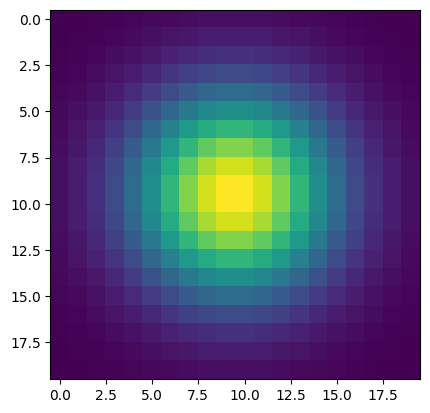

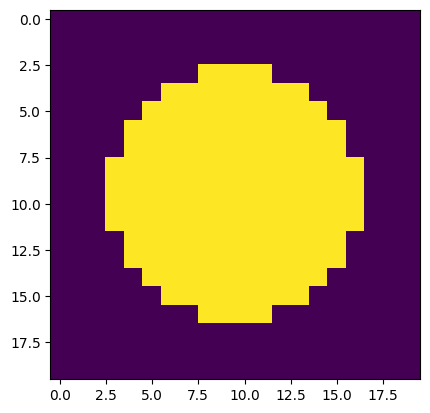

In [316]:
from src.datasets.tsm_scan import gaussian_blob
import albumentations as albu

synth_params = scan.synth_params
anomaly_template = gaussian_blob(size=20, sigma=0.4)
plt.imshow(anomaly_template)
plt.figure()
plt.imshow(anomaly_template > 0.2)
for scan in dataset.scans:
    scan.synth_params['p'] = 1.0
    scan.anomaly_template = anomaly_template
    scan.anomaly_template_mask = (anomaly_template > 0.25).astype(np.uint8)
    scan.anomaly_transforms = albu.Compose(
                [
                    albu.RandomScale(scale_limit=(-0.25, 0), p=1.0),
                    # albu.ElasticTransform(p=1.0, sigma=10, alpha_affine=20, border_mode=cv2.BORDER_CONSTANT),
                    albu.GridDistortion(num_steps=1, distort_limit=(-0.2, 0.2), border_mode=cv2.BORDER_CONSTANT, value=0),
                    albu.Rotate(limit=(-90, 90), border_mode=cv2.BORDER_CONSTANT),
                ]
            )
    
#     print(scan.synth_params)
#     break

150 / 23903
(256, 256, 3)


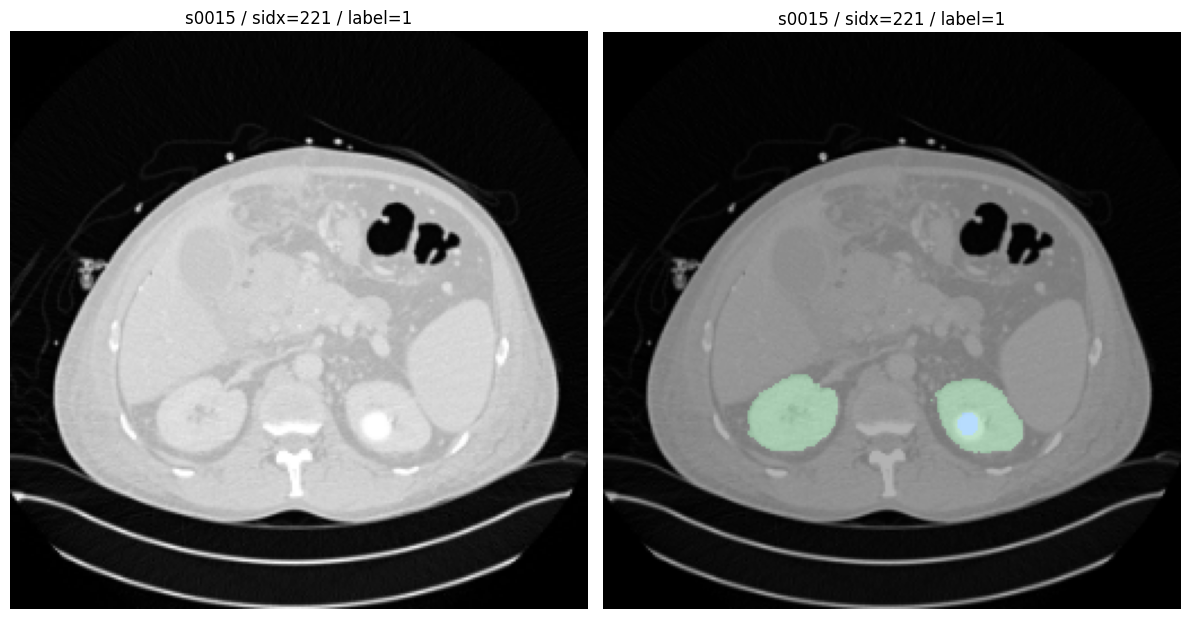

In [330]:
CLASS_COLORS['cyst'] = 235, 64, 52
CLASS_COLORS['tumor'] = 173, 66, 245
CLASS_COLORS['gaussian'] = 18, 140, 255

# idx = -100
idx = 150
s = dataset[idx]

print(idx, '/', len(dataset))

# np.stack([s['masks'][j].numpy()]*3, -1).astype(np.uint8) * np.array(color).reshape(1, 1, 3)

colors = [CLASS_COLORS[c] for c in dataset.classes[1:]]
# colors = [CLASS_COLORS[c] for c in ['kidney', 'tumor', 'cyst']]
# colors = [CLASS_COLORS[c] for c in dataset.classes[1:]]
# print(s['masks'].shape)

visualize_sample(s, colors, eq=False)
# plt.title(s['label'])
# o = s['image']
# plt.imshow(o[0])



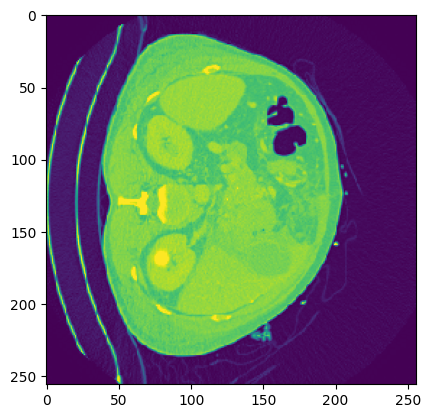

In [126]:
plt.imshow(s['masks'][-1])

In [11]:
sum(labels), len(labels),

NameError: name 'labels' is not defined

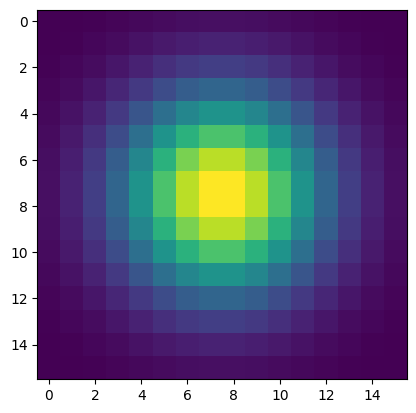

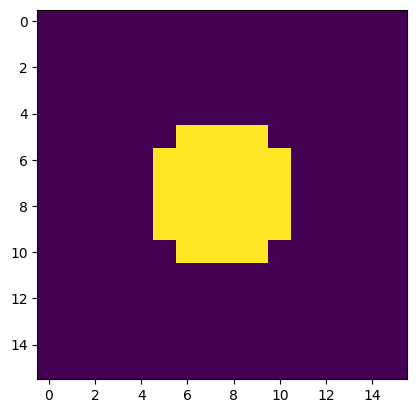

In [93]:
from src.datasets.tsm_scan import gaussian_blob

synth_params = scan.synth_params
anomaly_template = gaussian_blob(size=16, sigma=0.4)
plt.imshow(anomaly_template)
plt.figure()
plt.imshow(anomaly_template > 0.5)
for scan in dataset.scans:
    scan.synth_params['p'] = 1.0
    scan.anomaly_template = anomaly_template
    
#     print(scan.synth_params)
#     break

In [92]:
CLASS_COLORS['cyst'] = 235, 64, 52
CLASS_COLORS['tumor'] = 173, 66, 245

idx = -80
# idx = 100
s = dataset[idx]

print(idx, '/', len(dataset))

# np.stack([s['masks'][j].numpy()]*3, -1).astype(np.uint8) * np.array(color).reshape(1, 1, 3)

# colors = [CLASS_COLORS[c] for c in dataset.classes[1:]]
colors = [CLASS_COLORS[c] for c in ['kidney', 'tumor', 'cyst']]
# colors = [CLASS_COLORS[c] for c in dataset.classes[1:]]
print(s['masks'].shape)

# visualize_sample(s, colors, eq=False)
plt.title(s['label'])
# torch.flp
o = s['image']
# o = s['image'].transpose(2, 1).flip(2)

# o = s['masks'].transpose(1, 0).fliplr()
plt.imshow(o[0])
plt.figure()
plt.imshow(s['masks'][1])
plt.imshow(s['masks'][2])

# plt.imshow(o)


AttributeError: 'CTScan' object has no attribute 'anomaly_template_mask'

In [13]:
from pathlib import Path


tsm1_scans = set()
control_scans = set()
total = 0
for p in Path('data/totalsegmentor/').rglob('s*.nii.gz'):
    if p.parent == 'nnUNet_predictions':
        continue
    print(p)
    if p.parent.name == 'control':
        control_scans.add(p.name) 
    assert Path('data/totalsegmentor/nnUNet_predictions/', p.name).exists(), p.name
    tsm1_scans.add(p.name)
    total += 1
total
# print(p.parent, p.name)

data/totalsegmentor/train/control/s0992.nii.gz
data/totalsegmentor/train/control/s1131.nii.gz
data/totalsegmentor/train/control/s0039.nii.gz
data/totalsegmentor/train/control/s0626.nii.gz
data/totalsegmentor/train/control/s0686.nii.gz
data/totalsegmentor/train/control/s0257.nii.gz
data/totalsegmentor/train/control/s0739.nii.gz
data/totalsegmentor/train/control/s1085.nii.gz
data/totalsegmentor/train/control/s0102.nii.gz
data/totalsegmentor/train/control/s0168.nii.gz
data/totalsegmentor/train/control/s0329.nii.gz
data/totalsegmentor/train/control/s0618.nii.gz
data/totalsegmentor/train/control/s0304.nii.gz
data/totalsegmentor/train/control/s0486.nii.gz
data/totalsegmentor/train/control/s0473.nii.gz
data/totalsegmentor/train/control/s0446.nii.gz
data/totalsegmentor/train/control/s0165.nii.gz
data/totalsegmentor/train/control/s0635.nii.gz
data/totalsegmentor/train/control/s0393.nii.gz
data/totalsegmentor/train/control/s0092.nii.gz
data/totalsegmentor/train/control/s0161.nii.gz
data/totalseg

924

In [8]:
len(control_scans)

170

In [11]:
170*0.15

25.5

In [28]:
import random, shutil

random.seed(5)

cyst_scans_in_v2 = ['s0031.nii.gz', 's0046.nii.gz', 's0052.nii.gz', 's0054.nii.gz', 's0078.nii.gz', 's0091.nii.gz', 's0105.nii.gz', 's0147.nii.gz', 's0150.nii.gz', 's0178.nii.gz', 's0300.nii.gz', 's0390.nii.gz', 's0406.nii.gz', 's0555.nii.gz', 's0571.nii.gz', 's0583.nii.gz', 's0587.nii.gz', 's0591.nii.gz', 's0621.nii.gz', 's0656.nii.gz', 's0699.nii.gz', 's0705.nii.gz', 's0723.nii.gz', 's0752.nii.gz', 's0796.nii.gz', 's0822.nii.gz', 's0864.nii.gz', 's0939.nii.gz', 's0950.nii.gz', 's1221.nii.gz', 's1298.nii.gz', 's1334.nii.gz', 's1348.nii.gz', 's1373.nii.gz', 's1383.nii.gz', 's1391.nii.gz', 's1400.nii.gz', 's0013.nii.gz', 's0119.nii.gz', 's0735.nii.gz', 's1425.nii.gz']
cyst_scans_in_v2 = set(cyst_scans_in_v2)

final_control_scans = list(control_scans - cyst_scans_in_v2)
random.shuffle(final_control_scans)

controls_train = final_control_scans[:-26]
controls_test = final_control_scans[-26:]


dst = Path('./data/totalsegmentor-v1-controls')
labels_path = dst / 'nnUNet_predictions'
labels_path.mkdir(parents=True, exist_ok=True)

train_scans = dst / 'train'
train_scans.mkdir(parents=True, exist_ok=True)
test_scans = dst / 'test'
test_scans.mkdir(parents=True, exist_ok=True)

for p in Path('data/totalsegmentor/').rglob('s*.nii.gz'):
    if p.name not in final_control_scans:
        continue
      
    if p.parent.name == 'nnUNet_predictions':
        shutil.copy2(p, labels_path)
        continue
    if p.name in controls_train:
        shutil.copy2(p, train_scans)
    elif p.name in controls_test:
        shutil.copy2(p, test_scans)


In [25]:
p

PosixPath('data/totalsegmentor/nnUNet_predictions/s1069.nii.gz')

In [ ]:
# removed = set()

# total = 0
# for p in Path('data/totalsegmentor-v2').rglob('s*.nii.gz'):
#     if p.name not in tsm1_scans:
#         p.unlink()
#         removed.add(p.name)
#     if p.parent.name != 'original-labels':
#         total += 1
# #     print(p)

In [2]:
from tqdm import tqdm
import nibabel as nib
from pathlib import Path

KITS_LABEL_NAMES = {
  "kidney": 1,
  "tumor": 2, 
  "cyst": 3
}


ln = {}

for c in ('cyst', 'tumor'):
    names = []
    labels = []
    areas = []
    for p in tqdm(list(Path('data/kits23/').rglob('segmentation.nii.gz'))):
        ct_scan = nib.load(p) # loads the file. this usually comes with lots of metadata

        numpy_volume = ct_scan.get_fdata() # to just work with numpy array use get_fdata() method
        area = (numpy_volume == KITS_LABEL_NAMES[c]).sum()
        label = area > 16
        labels.append(label)
        names.append(p.parent.name)
        areas.append(area)
    ln[c] = {'labels': labels, 'names': names, 'areas': areas}
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [01:15<00:00,  6.45it/s]


In [5]:
# shapes = set()

# minmax = set()
# for p in tqdm(list(Path('data/kits23/').rglob('imaging.nii.gz'))):
#     ct_scan = nib.load(p) # loads the file. this usually comes with lots of metadata

#     numpy_volume = ct_scan.get_fdata() # to just work with numpy array use get_fdata() method
#     shapes.add(numpy_volume.shape)
    
#     minmax.add((numpy_volume.min(), numpy_volume.max()))
# shapes

In [463]:
for c, k in ln.items():
    print(c, sum(k['labels']), '/', len(k['labels']))

cyst 248 / 489
tumor 489 / 489


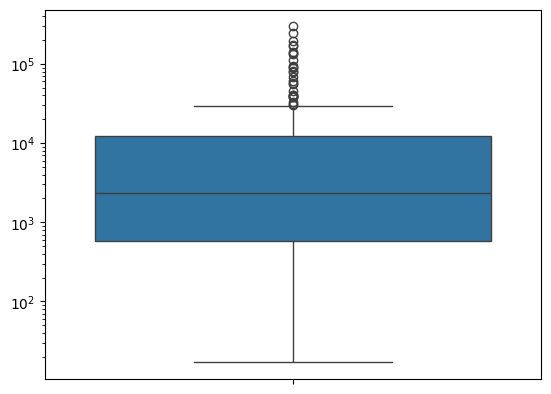

In [47]:
import seaborn as sns
from matplotlib import pyplot as plt

areas = np.array(ln['cyst']['areas'])

sns.boxplot(areas[areas != 0])
plt.yscale('log')

In [48]:
np.percentile(areas[areas != 0], [25, 50, 75])

array([  588.  ,  2317.5 , 12134.75])

In [21]:
import numpy as np
from collections import Counter


def equal_bin(areas):
    p1, p2, p3 = np.percentile(areas[areas != 0], [25, 50, 75])
    
    res = np.zeros_like(areas)
    res[(0 < areas) & (areas < p1)] = 1
    res[(p1 < areas) & (areas < p2)] = 2
    res[(p2 < areas) & (areas < p3)] = 3
    res[areas > p3] = 4
    
    return (p1, p2, p3), res

# sns.boxplot(areas[areas != 0], log_scale=True)


bins, bin_idxs = equal_bin(np.array(ln['cyst']['areas']))
print(bins)
print(sorted(Counter(bin_idxs).items(), key=lambda l: l[0]))

ln['cyst']['labels_area'] = bin_idxs

bins, bin_idxs = equal_bin(np.array(ln['tumor']['areas']))
ln['tumor']['labels_area'] = bin_idxs
print(bins)
sorted(Counter(bin_idxs).items(), key=lambda l: l[0])

(588.0, 2317.5, 12134.75)
[(0, 241), (1, 62), (2, 62), (3, 62), (4, 62)]
(5349.0, 17522.0, 67073.0)


[(0, 3), (1, 122), (2, 121), (3, 121), (4, 122)]

In [24]:
ln['cyst']['labels_area']

array([0, 1, 2, 2, 2, 1, 0, 1, 0, 3, 1, 3, 4, 2, 2, 1, 3, 1, 0, 0, 0, 4,
       2, 0, 3, 0, 2, 0, 4, 4, 0, 2, 1, 3, 4, 0, 3, 4, 1, 0, 1, 0, 4, 0,
       0, 0, 3, 2, 0, 0, 4, 0, 4, 4, 2, 3, 0, 1, 1, 3, 0, 0, 3, 1, 0, 1,
       1, 3, 0, 4, 1, 0, 0, 0, 1, 4, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4,
       2, 3, 3, 4, 4, 3, 0, 0, 2, 0, 0, 2, 4, 0, 3, 0, 3, 3, 2, 0, 0, 2,
       4, 0, 0, 0, 2, 1, 4, 2, 0, 3, 1, 0, 1, 0, 0, 3, 2, 0, 0, 0, 0, 1,
       0, 0, 3, 0, 0, 0, 3, 0, 0, 1, 4, 1, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0,
       4, 0, 2, 4, 0, 4, 0, 0, 1, 2, 0, 0, 4, 4, 0, 0, 1, 0, 3, 0, 0, 0,
       2, 0, 0, 0, 4, 0, 2, 0, 3, 0, 2, 0, 0, 3, 2, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 4, 0, 0, 0, 0, 2, 1, 4, 0, 1, 1, 2, 1, 4, 0, 0, 3, 0, 2, 0,
       0, 4, 0, 0, 0, 3, 3, 1, 2, 0, 4, 1, 0, 3, 0, 2, 3, 2, 0, 4, 4, 0,
       3, 4, 0, 1, 4, 3, 0, 0, 0, 0, 1, 4, 3, 0, 0, 0, 0, 2, 0, 0, 0, 4,
       3, 0, 2, 0, 0, 2, 3, 0, 0, 2, 4, 2, 0, 0, 0, 4, 0, 0, 3, 1, 0, 2,
       0, 3, 1, 0, 3, 0, 0, 1, 1, 0, 3, 0, 4, 4, 2,

In [23]:
ln['tumor']['labels_area']

array([2, 1, 2, 3, 4, 2, 2, 1, 4, 1, 2, 1, 2, 2, 3, 1, 2, 1, 1, 1, 4, 4,
       4, 1, 4, 2, 2, 3, 4, 2, 3, 3, 1, 4, 4, 1, 1, 3, 1, 4, 2, 4, 4, 1,
       3, 3, 3, 1, 2, 4, 4, 1, 2, 2, 1, 1, 3, 2, 1, 2, 3, 4, 4, 4, 1, 1,
       3, 2, 2, 4, 1, 1, 2, 3, 2, 1, 1, 4, 4, 2, 3, 1, 4, 1, 3, 4, 3, 3,
       2, 3, 3, 3, 3, 3, 1, 3, 1, 3, 2, 3, 3, 1, 2, 4, 1, 4, 1, 4, 0, 2,
       2, 1, 4, 2, 1, 2, 1, 1, 4, 2, 1, 1, 4, 4, 2, 3, 4, 3, 1, 2, 1, 4,
       2, 3, 1, 4, 2, 4, 2, 3, 2, 3, 4, 3, 3, 3, 1, 1, 4, 4, 4, 1, 2, 2,
       2, 3, 1, 3, 1, 3, 4, 3, 2, 4, 4, 1, 1, 1, 3, 3, 1, 4, 2, 3, 4, 4,
       1, 3, 1, 2, 1, 3, 3, 3, 4, 4, 1, 1, 2, 4, 4, 3, 3, 1, 1, 2, 2, 3,
       2, 3, 3, 2, 3, 4, 4, 3, 1, 3, 4, 2, 0, 3, 1, 1, 3, 1, 4, 4, 1, 3,
       3, 0, 2, 4, 2, 4, 4, 4, 4, 1, 2, 2, 2, 4, 3, 3, 1, 2, 1, 3, 2, 4,
       2, 2, 2, 2, 2, 4, 3, 1, 4, 3, 3, 3, 2, 1, 4, 4, 1, 3, 4, 2, 1, 2,
       2, 2, 2, 3, 4, 2, 2, 1, 2, 3, 4, 1, 2, 3, 2, 2, 2, 4, 4, 2, 2, 1,
       2, 1, 2, 2, 4, 2, 1, 1, 1, 1, 3, 2, 1, 3, 4,

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np


num_splits = 4

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=4)

for cn in ln:
    names, labels, areas = ln[cn]['names'], ln[cn]['labels_area'], ln[cn]['areas']
    
    for i, (train_index, test_index) in enumerate(cv.split(names, labels)):
        train_names = [names[i] for i in train_index]
        train_labels = [labels[i] for i in train_index]
        train_areas = [areas[i] for i in train_index]

        sp = Path(f'data/kits23/splits/skf_{cn}_area_split{i}')
        sp.mkdir(exist_ok=True, parents=True)
        with open(sp / 'train_scans.csv', 'w') as fid:
            fid.write('\n'.join(sorted(train_names)))

        test_names = [names[i] for i in test_index]
        test_labels = [labels[i] for i in test_index]
        test_areas = [areas[i] for i in test_index]

    #     fig
        train_areas = np.array(train_areas)
        print(train_areas.min(), train_areas.max(), train_areas.std(), np.median(train_areas))


        test_areas = np.array(test_areas)
        print(test_areas.min(), test_areas.max(), test_areas.std(), np.median(test_areas))

    #     sns.boxplot(, log_scale=True, figure=plt.figure())
    #     sns.boxplot(test_areas, log_scale=True)
        with open(sp / 'test_scans.csv', 'w') as fid:
            fid.write('\n'.join(sorted(test_names)))

        print(sum(map(bool, train_labels)), '/', sum(map(bool, test_labels)))
    print()
#     sns.boxplot()
#     break
# train_test_split(names, test_size=)


0 244433 26394.174109104628 47.5
0 298154 30508.342456256953 50.0
186 / 62
0 298154 30686.672206622876 52.0
0 87726 13672.060064624844 37.5
186 / 62
0 298154 23429.429627282894 50.0
0 244433 36941.19345142713 35.0
186 / 62
0 298154 28861.167706217933 43.0
0 175069 22855.649581328165 101.0
186 / 62

160 1848011 205949.78570115095 17478.0
659 3618369 409127.6287720809 17813.0
364 / 122
160 3618369 308172.27131383185 17522.0
629 542374 100771.78922901968 17557.5
364 / 122
465 3618369 283892.37364136253 17681.0
160 1816289 233875.54483862314 17036.0
365 / 121
160 3618369 279816.4704889557 17434.0
465 1848011 248261.1460832194 17773.0
365 / 121



/gpfs/space/home/dmytrosh/counterfactual-search/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(


In [451]:
removed = set()

total = 0
for p in Path('data/totalsegmentor-v2').rglob('s*.nii.gz'):
    if p.name not in tsm1_scans:
        p.unlink()
        removed.add(p.name)
    if p.parent.name != 'original-labels':
        total += 1
#     print(p)

In [455]:
with open('data/totalsegmentor-v2/removed_scans.txt', 'w') as f:
    f.write('\n'.join(sorted(removed)))
    

In [452]:
len(removed), total

(377, 832)

In [442]:
# ci = iter(np.nonzero(dataset.get_sampling_labels())[0])
sum(dataset.get_sampling_labels())

Number of slices with positive sampling label: 558


558

-795 / 36199
{'empty': 0, 'kidney_left': 1, 'kidney_cyst_left': 2, 'kidney_right': 3, 'kidney_cyst_right': 4}
(256, 256, 3)


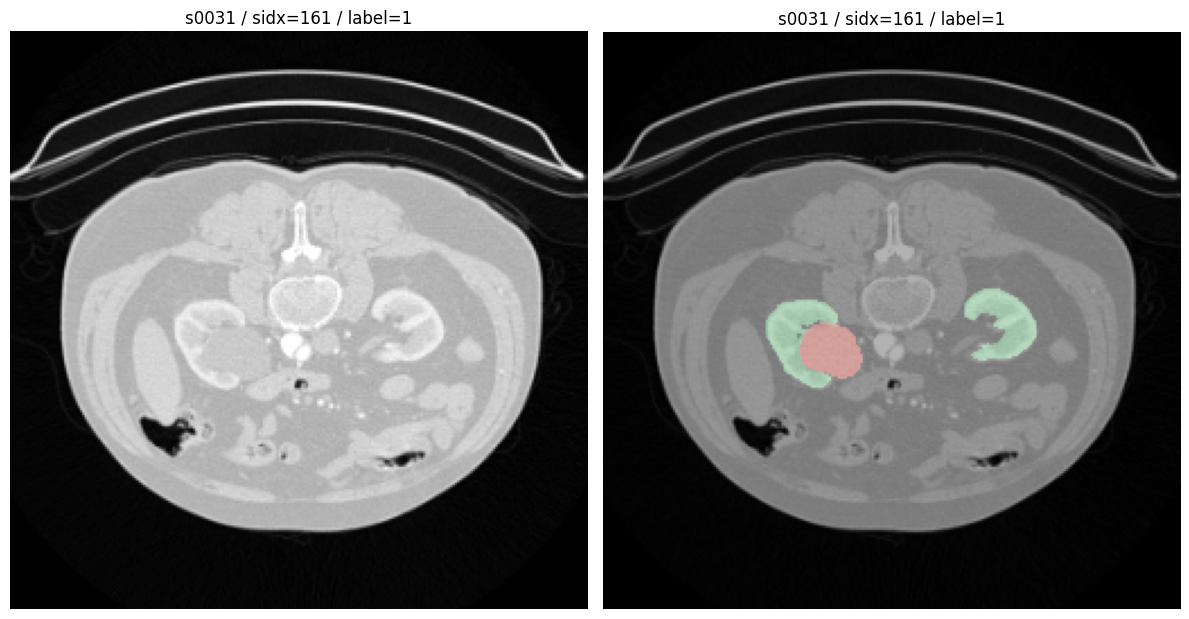

In [434]:
# idx = 0

# idx -= 50
# idx += 1
s = dataset[next(ci)]

print(idx, '/', len(dataset))

# np.stack([s['masks'][j].numpy()]*3, -1).astype(np.uint8) * np.array(color).reshape(1, 1, 3)

print(class_to_idx)
colors = [CLASS_COLORS[c] for c in dataset.classes[1:]]

visualize_sample(s, colors, eq=False)

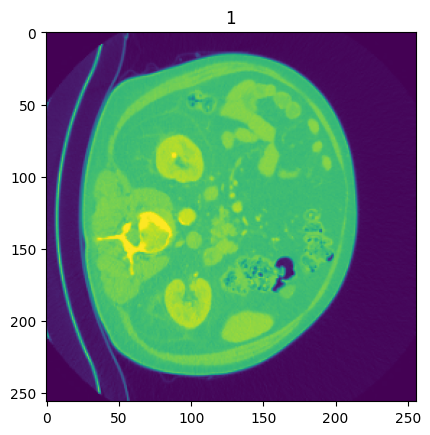

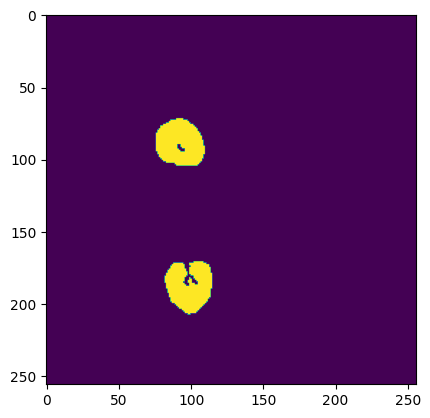

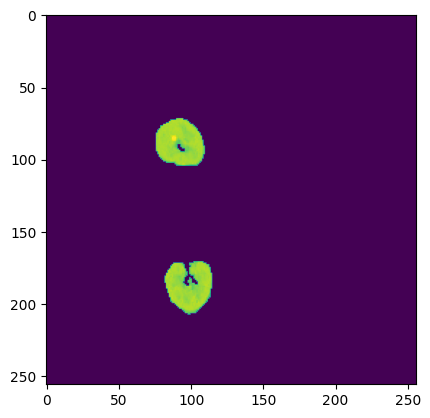

In [76]:
from matplotlib import pyplot as plt
idx = 3
plt.title(batch['label'][idx].item())
plt.imshow(batch['image'][idx][0])
plt.figure()
plt.imshow(batch['masks'][idx][0])
plt.figure()

batch['image'][idx][0] += 1
batch['image'][idx][0] /= 2
plt.imshow(batch['image'][idx][0] * batch['masks'][idx][0].bool(), vmin=batch['image'][idx][0].min())

In [75]:
batch['image'][idx][0]

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])

In [74]:
(batch['image'][idx][0] & batch['masks'][idx][0].bool()).max()

RuntimeError: "bitwise_and_cpu" not implemented for 'Float'

In [17]:
transforms

{'train': Compose([
   Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
   Normalize(always_apply=False, p=1.0, mean=[0.5], std=[0.5], max_pixel_value=255),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}),
 'val': Compose([
   Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
   Normalize(always_apply=False, p=1.0, mean=[0.5], std=[0.5], max_pixel_value=255),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})}

In [81]:
!pwd

/gpfs/space/home/dmytrosh/counterfactual-search


In [83]:
!ls training_logs/classification/resnet18-October-14-2023_01+03PM-af13228-tsm_synth_r18/checkpoints/checkpoint_55.pt

ls: cannot access training_logs/classification/resnet18-October-14-2023_01+03PM-af13228-tsm_synth_r18/checkpoints/checkpoint_55.pt: No such file or directory


In [98]:
from pathlib import Path
clf_config = 'configs/classification/resnet18_tsm_synthetic.yaml'
with open(clf_config) as fid:
    copt = yaml.safe_load(fid)
    copt = edict(copt)
seed_everything(copt.seed)

cmodel = build_model(copt.task_name, opt=copt.model, img_size=copt.dataset.img_size)
ctrainer = build_trainer(copt.task_name, copt, cmodel, continue_path=Path(opt.model.classifier_ckpt).parent.parent)

/gpfs/space/home/dmytrosh/counterfactual-search/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/space/home/dmytrosh/counterfactual-search/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[2023-10-15 12:13:54|INFO] - ================ Session (Sun Oct 15 12:13:54 2023) ================
[2023-10-15 12:13:54|INFO] - Logging directory: training_logs/classification/resnet18-October-14-2023_01+03PM-af13228-tsm_synth_r18
[2023-10-15 12:13:54|INFO] - Restored checkpoint training_logs/classification/resnet18-October-14-2023_01+03PM-af13228-tsm_synth_r18/checkpoints/checkpoint_55.pth (October 14, 202

In [99]:
cloaders = ctrainer.get_dataloaders()
ctrainer.validation_epoch(cloaders[1])

Instantiated training dataset for number of samples: 115394
Instantiated validation dataset for number of samples: 30683


[2023-10-15 12:14:13|INFO] - [Finished validation epoch 55/1000] [Epoch loss: 0.075510] [Epoch F1 score: 0.950345]       


{'loss': tensor(0.0755),
 'BinaryPrecision': tensor(0.9636, device='cuda:0'),
 'BinaryRecall': tensor(0.9374, device='cuda:0'),
 'BinaryF1Score': tensor(0.9503, device='cuda:0')}

In [100]:
cloaders = ctrainer.get_dataloaders()
ctrainer.validation_epoch(cloaders[1])

Exception ignored in: <function Logger.__del__ at 0x2b66aac3f550>
Traceback (most recent call last):
  File "/gpfs/space/home/dmytrosh/counterfactual-search/src/logger.py", line 35, in __del__
AttributeError: 'Logger' object has no attribute 'writer'


Instantiated training dataset for number of samples: 115394
Instantiated validation dataset for number of samples: 30683


[2023-10-15 12:14:47|INFO] - [Finished validation epoch 55/1000] [Epoch loss: 0.076116] [Epoch F1 score: 0.949947]       


{'loss': tensor(0.0761),
 'BinaryPrecision': tensor(0.9634, device='cuda:0'),
 'BinaryRecall': tensor(0.9369, device='cuda:0'),
 'BinaryF1Score': tensor(0.9499, device='cuda:0')}

In [90]:
torch.allclose(next(model.classifier_f.parameters()), next(cmodel.model.parameters()))

True

In [114]:
train_loader.dataset.scans[0].transforms

Compose([
  Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.5], std=[0.5], max_pixel_value=255),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [133]:
trainer.validation_epoch(val_loader)

[2023-10-15 13:13:42|INFO] - [Average of positives/negatives ratio in batch: 0]                                          


AttributeError: 'EasyDict' object has no attribute 'eval_counter_freq'

In [9]:
posterior_probs, _ = predict_probs(train_loader, self.model.classifier_f, task='binary' if self.model.n_classes == 1 else 'multiclass')
# sampler_labels = compute_sampler_condition_labels(posterior_probs, self.model.explain_class_idx, self.model.num_bins)

Precomputing posterior probabilities: 100%|██████████████████████████████████| 7213/7213 [02:13<00:00, 53.88it/s]


In [12]:
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.8 MB/s eta 0:00:003.4 MB/s eta 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [22]:
(np.array(posterior_probs) > 0.5).sum()

19036

In [14]:
(np.array(posterior_probs) < 0.05).sum()

95103

In [20]:
(np.array(posterior_probs) > 0.7).sum()

18701

In [11]:
np.array(posterior_probs).std()

0.36431053

In [10]:
np.array(posterior_probs).reshape(-1).max()

1.0

In [105]:
plt.hist(posterior_probs)


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x2b66509a4790> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x2b66b5ea1ee0> (for post_execute):



KeyboardInterrupt

